### CCD data analysis

Aufgabe 3)

In [6]:
# calculate rough gain estimates from relations with poisson statistic (eq 2.1 and 2.2)
N_adu, sigma_adu = 4.469995e3, 4.724514e1
green_gain = N_adu / sigma_adu**2

N_adu, sigma_adu = 3.245909e3 , 4.023987e1
blue_gain = N_adu / sigma_adu**2

print("blue [ADU]:", round(blue_gain, 3), "green [ADU]:", round(green_gain, 3))

blue [ADU]: 2.005 green [ADU]: 2.003


Aufgabe 4)

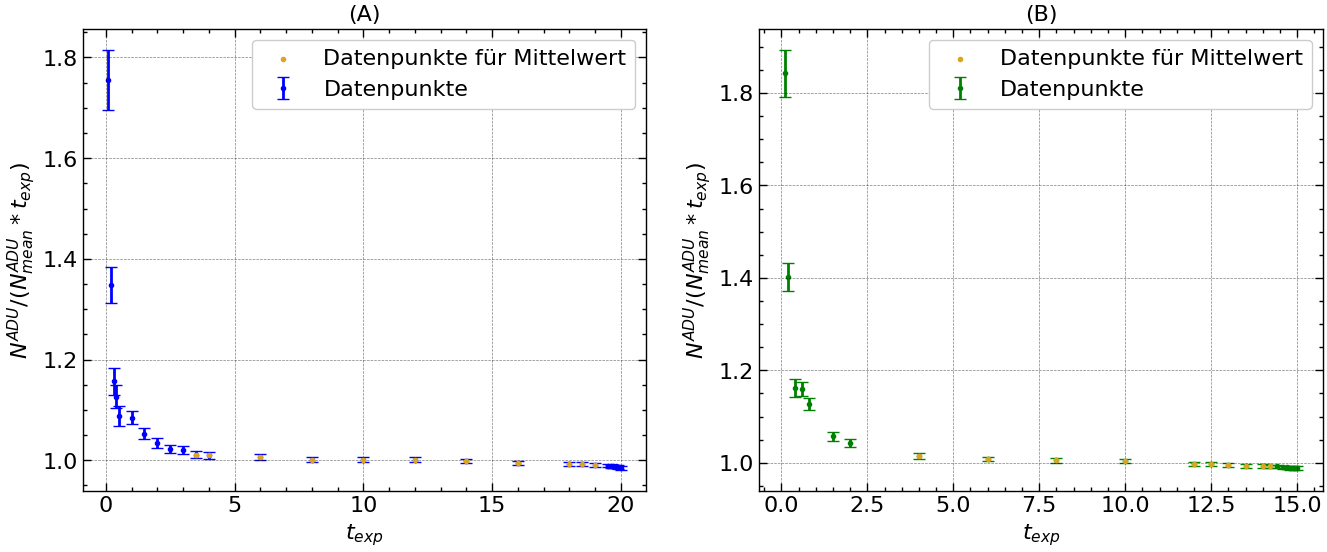

In [14]:
# plot N_adu against exposure time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science', 'notebook', 'grid', 'high-contrast'])
from uncertainties import ufloat, unumpy

def N_adu_vs_exposure_plot(color, thresholds):

    df = pd.read_csv(color+"_time.csv", header=0)

    # make uncertainty array
    N_full = unumpy.uarray(df["mean_"+color], df["std_"+color])

    # subset for calculating mean
    subset = df[(df["time"] > thresholds[0]) & (df["time"] < thresholds[1])]
    N_subset = unumpy.uarray(subset["mean_"+color], subset["std_"+color])
    N_mean = np.mean(subset["mean_"+color] / subset["time"]) # mean computed of y value!

    # Calculate y_values with uncertainties

    y_values = N_full / df["time"] / N_mean

    # Plot the data with error bars
    plt.errorbar(df["time"], unumpy.nominal_values(y_values), yerr=unumpy.std_devs(y_values),
                    ls="", elinewidth=2, capsize=4, color=color, marker=".", zorder=0, label="Datenpunkte")
    plt.scatter(subset["time"], unumpy.nominal_values(N_subset / subset["time"] / N_mean), c="goldenrod", marker=".", label="Datenpunkte für Mittelwert")
    # Add labels and a title
    plt.xlabel(r"$t_{exp}$")
    plt.ylabel(r"$N^{ADU} / (N^{ADU}_{mean} * t_{exp})$")
    plt.legend()

    

plt.figure(figsize=(16,6))
plt.subplot(121)
N_adu_vs_exposure_plot("blue", [3, 19.5])
plt.title("(A)")
plt.subplot(122)
N_adu_vs_exposure_plot("green", [2, 14.4])
plt.title("(B)")
plt.savefig("A4_plot.png", dpi=200)
plt.show() #hier noch die Fitwerte für den linearen Bereich angeben

Aufgabe 5)

blue free: a (5.15+/-0.35)e-06 b 0.519+/-0.020 c (-1.8+/-1.7)e+02
full well capacity: (1.09+/-0.04)e+05
blue with sigma: a (5.39+/-0.28)e-06 b 0.503+/-0.013
full well capacity: (1.121+/-0.030)e+05
green free: a (6.3+/-0.6)e-06 b 0.564+/-0.032 c (-3.3+/-2.8)e+02
full well capacity: (1.02+/-0.06)e+05
green with sigma: a (6.6+/-0.5)e-06 b 0.538+/-0.023
full well capacity: (1.06+/-0.05)e+05


Text(0.5, 1.0, '(B)')

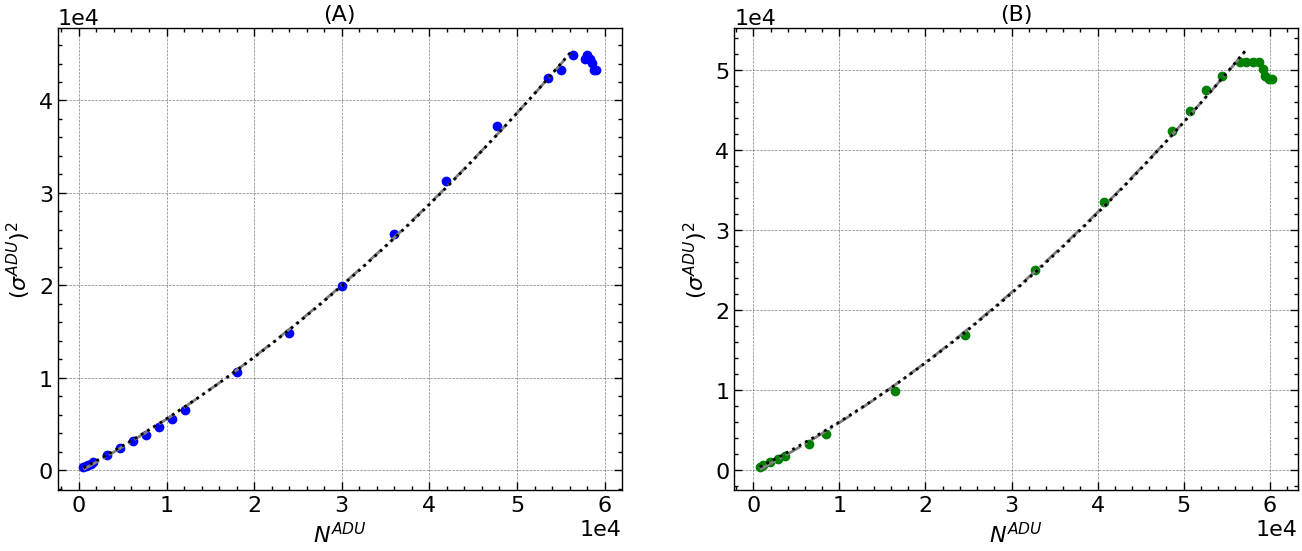

In [3]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import scienceplots
from uncertainties import ufloat
plt.style.use(['science', 'notebook', 'grid', 'high-contrast'])

def N_sigma_fits(color):
    # plot N_adu against sigma_adu^2
    df = pd.read_csv(color+"_time.csv", header=0)

    plt.scatter(df["mean_"+color], df["std_"+color]**2, c=color)

    # prepare data for fit
    x_data, y_data = df["mean_"+color][0:-6], df["std_"+color][0:-6]**2
    x_range = np.linspace(np.min(x_data), np.max(x_data), 200)

    # fit with general quadratic polynomial
    def quadratic_poly(x, a, b, c):
        return (a*x**2 + b*x + c)

    popt_1, pcov_1 = sp.optimize.curve_fit(quadratic_poly, x_data, y_data)
    plt.plot(x_range, quadratic_poly(x_range, popt_1[0], popt_1[1], popt_1[2]), ls="-.", c="grey", label="freier quadratischer Fit")
    print(color, "free:", "a", ufloat(popt_1[0], np.sqrt(pcov_1[0,0])), "b", ufloat(popt_1[1], np.sqrt(pcov_1[1,1])), "c", ufloat(popt_1[2], np.sqrt(pcov_1[2,2])))
    print("full well capacity:", np.max(x_data) / ufloat(popt_1[1], np.sqrt(pcov_1[1,1])))

    # fit with constant from sigma_ron (Aufgabe 2)
    sigma_ron = 1.773035e0
    def quadratic_poly_sig(x, a, b):
        return (a*x**2 + b*x + sigma_ron)

    popt_2, pcov_2 = sp.optimize.curve_fit(quadratic_poly_sig, x_data, y_data)
    plt.plot(x_range, quadratic_poly_sig(x_range, popt_2[0], popt_2[1]), ls=":", c="black", label=r"Fit mit $\sigma^{ADU}_{ron}$")
    print(color, "with sigma:", "a", ufloat(popt_2[0], np.sqrt(pcov_2[0,0])), "b", ufloat(popt_2[1], np.sqrt(pcov_2[1,1])))
    print("full well capacity:", np.max(x_data) / ufloat(popt_2[1], np.sqrt(pcov_2[1,1])))

    plt.xlabel(r"$N^{ADU}$")
    plt.ylabel(r"$(\sigma^{ADU})^2$")
    plt.ticklabel_format(axis="both", style="sci", scilimits=(4,4))

    return ([[popt_1, pcov_1], [popt_2, pcov_2]])


plt.figure(figsize=(16,6))
plt.subplot(121)
fit_params_blue = N_sigma_fits("blue")
plt.title("(A)")
plt.subplot(122)
fit_params_green = N_sigma_fits("green")
plt.title("(B)")

Aufgabe 6)

In [4]:
import numpy as np
from uncertainties import ufloat, umath

# calculate sigma_tot from results in Aufgabe 5)
def sigma_ron_e_from_ADU(fit_params):
    free_params, sig_params = fit_params

    # only calculate for sigma fit, since negative sigma_ron is not realistic
    sigma_ron = 1.773035e0

    g, k_2 = 1/ufloat(sig_params[0][1], np.sqrt(sig_params[1][1,1])), ufloat(sig_params[0][0], np.sqrt(sig_params[1][0,0]))

    print("sigma_ron_e: ", sigma_ron * g, " g: ", g, " k: ", umath.sqrt(k_2))

    return (g)


print("results using sigma fit blue:")
g_blue = sigma_ron_e_from_ADU(fit_params_blue)

print("results using sigma fit green:")
g_green = sigma_ron_e_from_ADU(fit_params_green)

results using sigma fit blue:
sigma_ron_e:  3.53+/-0.09  g:  1.99+/-0.05  k:  0.00232+/-0.00006
results using sigma fit green:
sigma_ron_e:  3.29+/-0.14  g:  1.86+/-0.08  k:  0.00258+/-0.00009


Aufgabe 8)

E_g, negative T:  0.16+/-0.05 eV
E_g, positive T:  1.16+/-0.27 eV


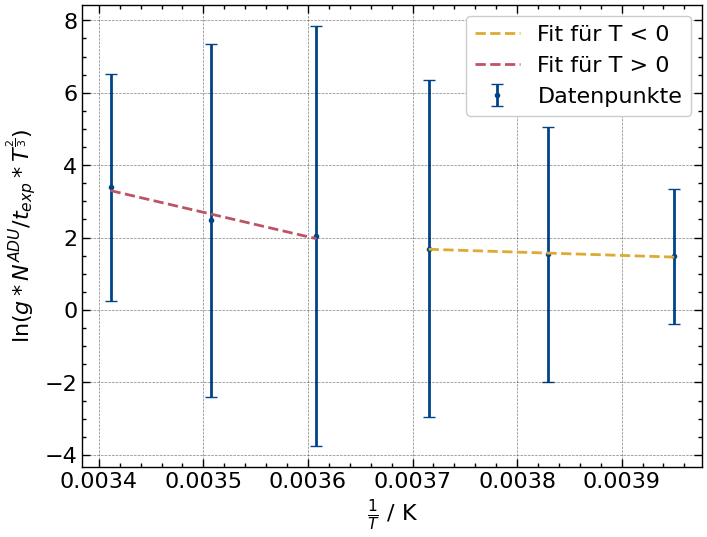

In [5]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from uncertainties import ufloat, unumpy

temp_df = pd.read_csv("temperature_data.csv", header=0)

temp_df["temp"] = temp_df["temp"] + 273.15

dark = unumpy.uarray(temp_df["mean"], temp_df["std"])

# calculate mean gain estimate from Aufgabe 6) results
g_mean = (g_blue + g_green) / 2
I_dark = g_mean * dark / temp_df["t_exp"]
I_dark_ln = unumpy.log(I_dark * temp_df["t_exp"]**(2/3))

def fitfun(T, E_g, const):
    return (-E_g/2/T + const)

x_vals = 1/temp_df["temp"]
plt.errorbar(x_vals, unumpy.nominal_values(I_dark_ln), yerr=unumpy.std_devs(I_dark_ln),
                    ls="", elinewidth=2, capsize=4, marker=".", zorder=0, label="Datenpunkte")

popt, pcov = sp.optimize.curve_fit(fitfun, temp_df["temp"][0:3], unumpy.nominal_values(I_dark_ln)[0:3])
x_range = np.linspace(np.min(x_vals[0:3]), np.max(x_vals[0:3]), 200)
plt.plot(x_range, fitfun(1/x_range, popt[0], popt[1]), ls="--", label="Fit für T < 0")
print("E_g, negative T: ", ufloat(popt[0], np.sqrt(pcov[0,0])) * sp.constants.k / sp.constants.e, "eV")

popt, pcov = sp.optimize.curve_fit(fitfun, temp_df["temp"][3:], unumpy.nominal_values(I_dark_ln)[3:])
x_range = np.linspace(np.min(x_vals[3:]), np.max(x_vals[3:]), 200)
plt.plot(x_range, fitfun(1/x_range, popt[0], popt[1]), ls="--", label="Fit für T > 0")
print("E_g, positive T: ", ufloat(popt[0], np.sqrt(pcov[0,0])) * sp.constants.k / sp.constants.e, "eV")

plt.xlabel(r"$\frac{1}{T}$ / K")
plt.ylabel(r"$\ln(g*N^{ADU}/t_{exp} * T^\frac{2}{3})$")
plt.legend()